In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Rain Prediction/rainfall_dataset.csv")
df = df.set_index('date_time')
df.index = pd.to_datetime(df.index)

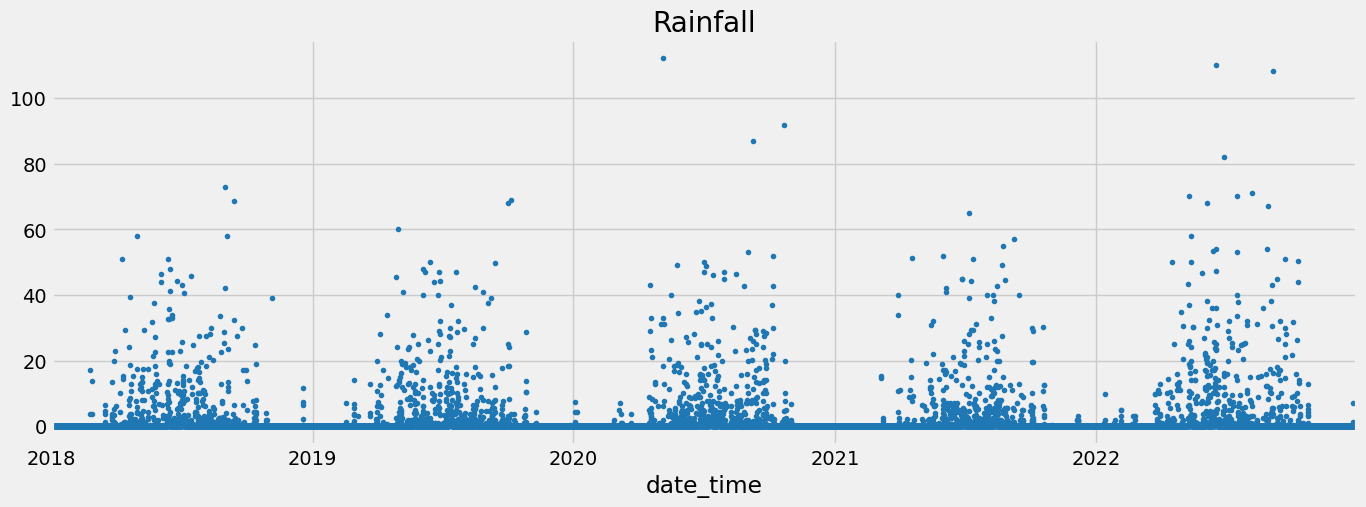

In [ ]:
df['rainfall'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Rainfall')
plt.show()

# Train / Test Split

In [ ]:
train = df.iloc[:13148]
test = df.iloc[13148:]

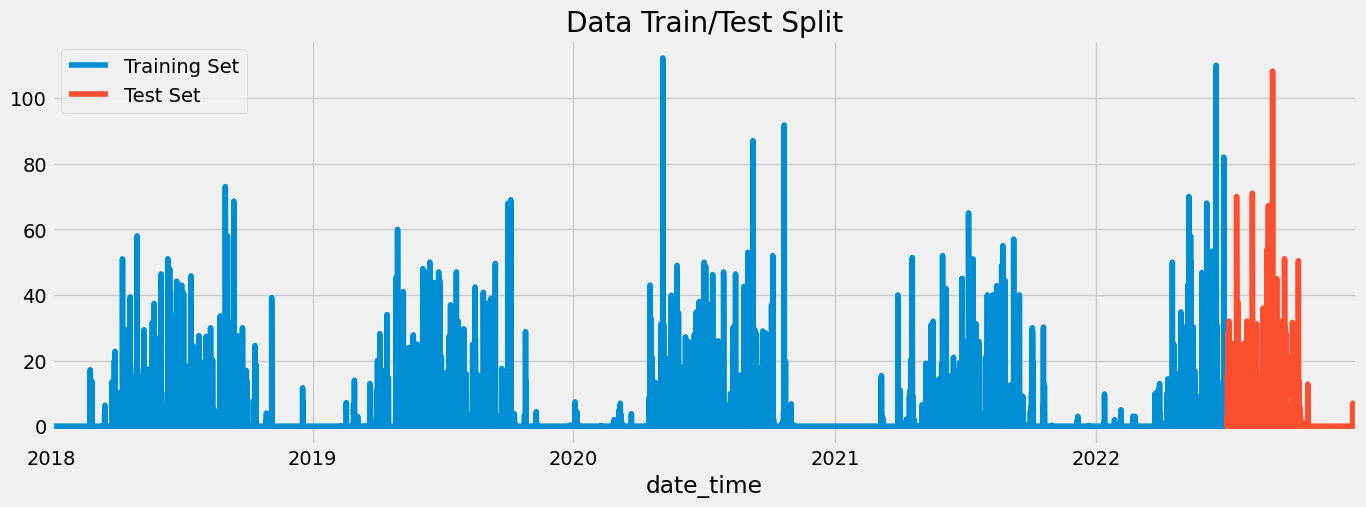

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train['rainfall'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['rainfall'].plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Time Series Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=8*365*1, gap=3)
df = df.sort_index()

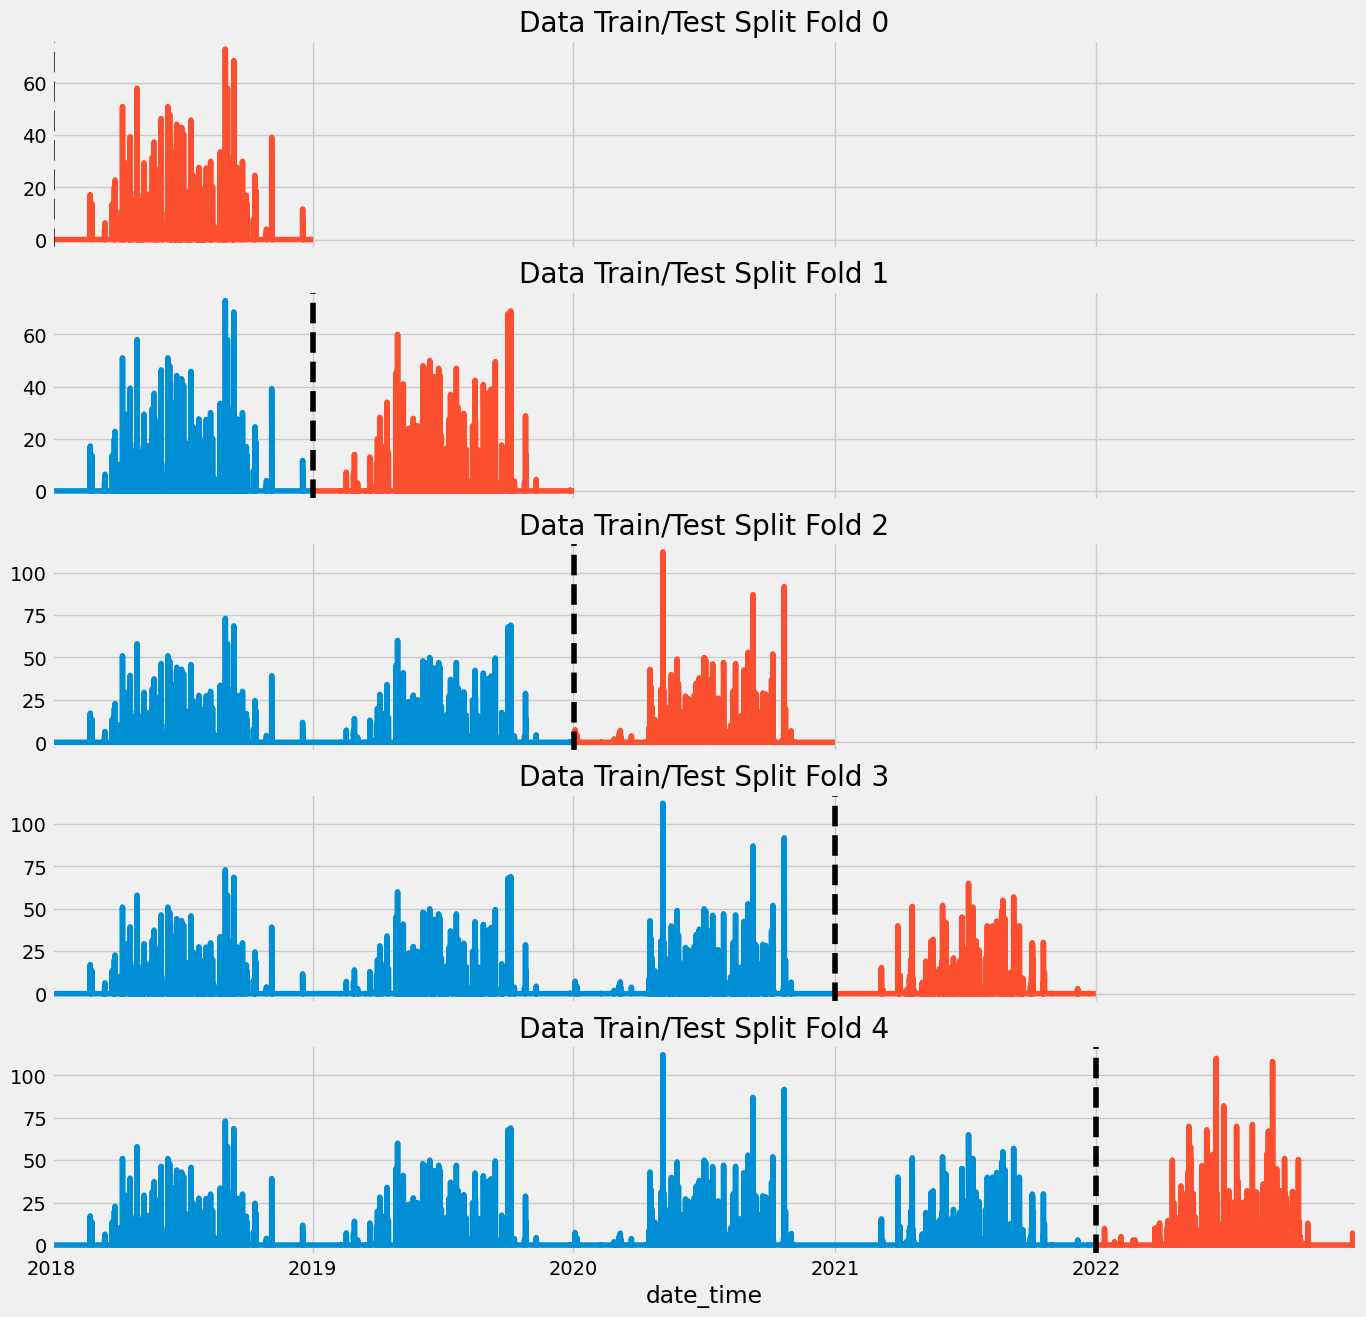

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['rainfall'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['rainfall'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

# Feature Creation

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
def add_lags(df):
    target_map = df['rainfall'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

In [ ]:
df.head()

,rainfall,relative_humidity,temperature,wind_speed_SP,wind_speed_DR,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
date_time,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,98,16.5,2,8,0,0,1,1,2018,1,1,1,NaN,NaN,NaN
2018-01-01 03:00:00,0.0,74,19.2,3,9,3,0,1,1,2018,1,1,1,NaN,NaN,NaN
2018-01-01 06:00:00,0.0,57,25.7,3,12,6,0,1,1,2018,1,1,1,NaN,NaN,NaN
2018-01-01 09:00:00,0.0,58,26.2,4,13,9,0,1,1,2018,1,1,1,NaN,NaN,NaN
2018-01-01 12:00:00,0.0,77,23.0,0,0,12,0,1,1,2018,1,1,1,NaN,NaN,NaN


# Train Using Cross Validation

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=8*365*1, gap=3)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)


    FEATURES = ['relative_humidity', 'temperature', 'wind_speed_SP',
       'wind_speed_DR', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3']

    TARGET = 'rainfall'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[17:12:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49583	validation_1-rmse:5.38462
[49]	validation_0-rmse:0.32905	validation_1-rmse:5.40976
[17:12:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.36326	validation_1-rmse:5.32046
[100]	validation_0-rmse:4.38788	validation_1-rmse:4.53305
[200]	validation_0-rmse:4.06765	validation_1-rmse:4.50362
[221]	validation_0-rmse:4.02738	validation_1-rmse:4.51080
[17:12:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.34177	validation_1-rmse:6.15257
[100]	validation_0-rmse:4.50988	validation_1-rmse:5.37044
[200]	validation_0-rmse:4.23844	validation_1-rmse:5.15093
[300]	validation_0-rmse:4.15242	validation_1-rmse:5.10726
[400]	validation_0-rmse:4.08913	validation_1-rmse:5.08658
[500]	valida

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4.9649
Fold scores:[5.384616564961198, 4.497646048206826, 5.074119237707092, 4.059288246225938, 5.808587153676616]


# Feature Importance

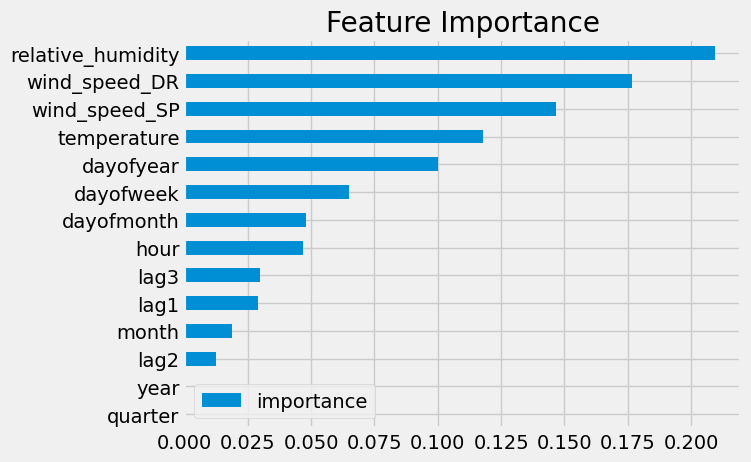

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Predicting the Future

In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['relative_humidity', 'temperature', 'wind_speed_SP',
       'wind_speed_DR', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3']

TARGET = 'rainfall'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[17:17:47] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.88248
[100]	validation_0-rmse:4.97326
[200]	validation_0-rmse:4.72908
[300]	validation_0-rmse:4.62280
[400]	validation_0-rmse:4.55343
[499]	validation_0-rmse:4.51842


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [ ]:
df.index.max()

Timestamp('2022-12-31 21:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2021-01-01','2022-01-01', freq='3h')

future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

# Predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

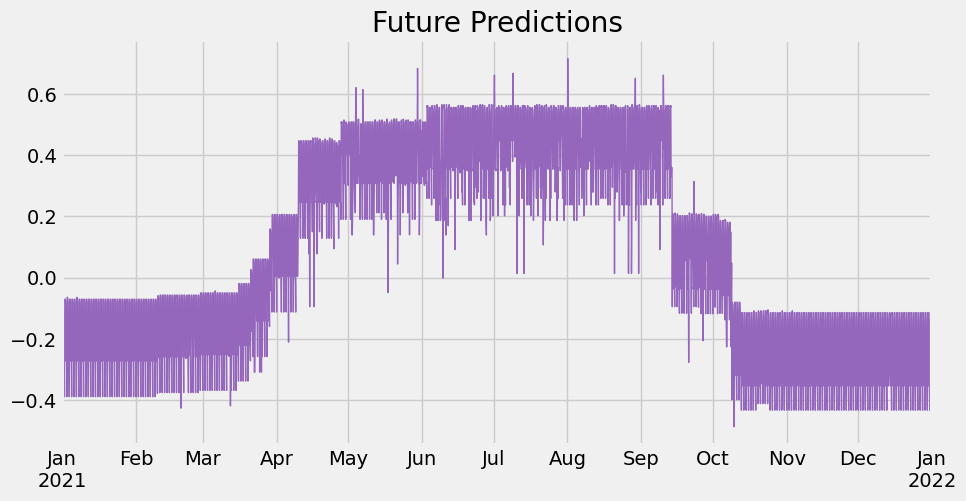

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()